**ML COURSE 2024-2025**
# LAB8  NEURAL NETWORKS 2 


## Convolutional Neural Networks (CNNs) - usate principalmente per immagini

Convolutional Neural Networks (CNNs) are built from several key layers:

- **Convolutional layers**: These use sparse filters to capture spatial patterns, making them ideal for tasks like image recognition.
- **Pooling layers**: Pooling reduces the sensitivity of the network to small translations in the input, ensuring that small shifts in the input don't dramatically affect the output.
- **Dense layers**: These fully connected layers perform high-level reasoning after the convolutional and pooling layers.

The [LeNet architecture](https://ieeexplore.ieee.org/abstract/document/726791) is often considered the foundation of CNNs. In this project, we’ll design a network inspired by LeNet's structure. We will design it using Keras.

In [1]:
import tensorflow as tf
import numpy as np

2025-06-04 14:29:31.925159: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-04 14:29:32.353714: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749047372.525415    7403 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749047372.579516    7403 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749047372.918786    7403 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

### Fashion-MNIST

**Fashion-MNIST** is a benchmark dataset designed as a more challenging drop-in replacement for the original MNIST handwritten digits dataset. It contains grayscale images of fashion products from 10 categories, aiming to better represent modern computer vision tasks.

- **Number of samples**: 70,000 (60,000 training, 10,000 test)
- **Image size**: 28×28 pixels
- **Color channels**: Grayscale (1 channel)
- **Number of classes**: 10
- **Categories**:

  0. T-shirt/top  
  1. Trouser  
  2. Pullover  
  3. Dress  
  4. Coat  
  5. Sandal  
  6. Shirt  
  7. Sneaker  
  8. Bag  
  9. Ankle boot

Fashion-MNIST serves as a more realistic alternative to MNIST, offering similar ease of use while presenting a greater challenge for modern algorithms.


In [2]:
# Load Fashion MNIST instead of MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Normalize (scale) the pixel values to [0, 1]
x_train, x_test = x_train / 255.0, x_test / 255.0

Text(0.5, 1.0, 'Class distribution in test dataset')

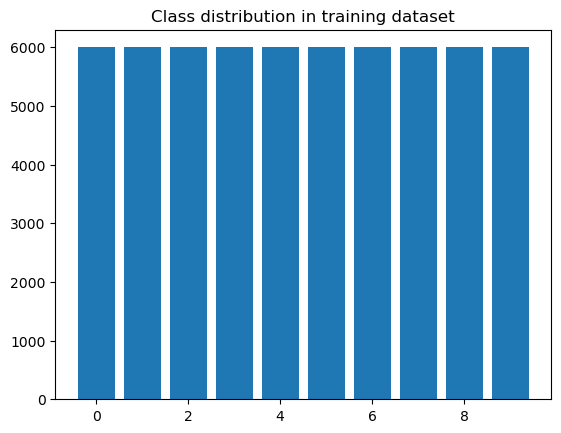

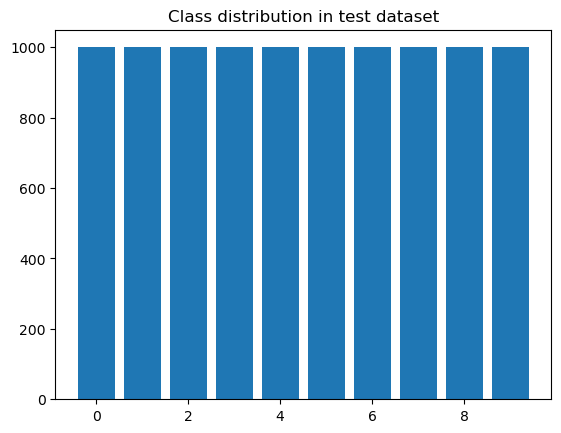

In [3]:
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt

# Count the number of occurrences of each digit in the training labels
train_class_counter = Counter(y_train) #dictionary with keys as digits and values as counts

# Create a new figure and plot a bar chart for the training set class distribution
plt.figure()
plt.bar(train_class_counter.keys(), train_class_counter.values())
plt.title('Class distribution in training dataset')  # Title for the plot

# Count the number of occurrences of each digit in the test labels
test_class_counter = Counter(y_test)

# Create a new figure and plot a bar chart for the test set class distribution
plt.figure()
plt.bar(test_class_counter.keys(), test_class_counter.values())
plt.title('Class distribution in test dataset')  # Title for the plot

Class of x_train: <class 'numpy.ndarray'>
Class of y_train: <class 'numpy.ndarray'>
Shape of x_train: (60000, 28, 28)
Shape of y_train: (60000,)
Shape of x_test: (10000, 28, 28)
Shape of y_test: (10000,)


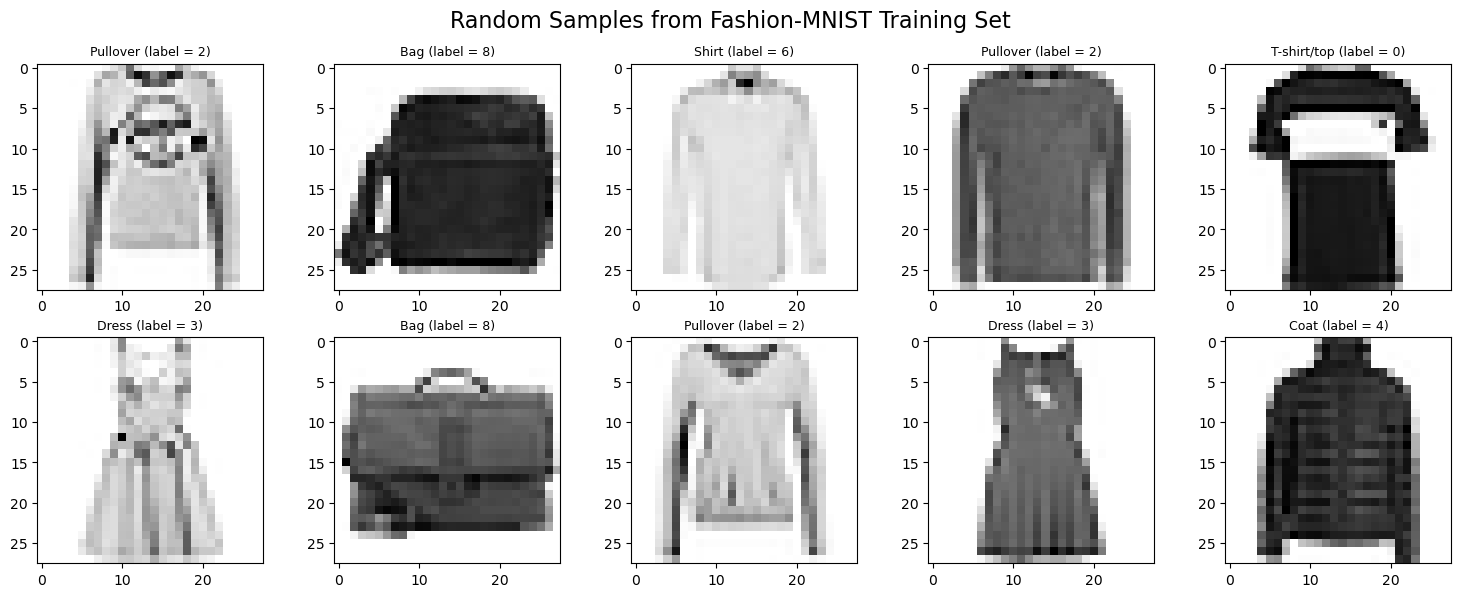

In [4]:
# Print data type and shape information for training and test sets
print('Class of x_train: {}'.format(type(x_train)))
print('Class of y_train: {}'.format(type(y_train)))  
print('Shape of x_train: {}'.format(x_train.shape))  
print('Shape of y_train: {}'.format(y_train.shape)) 
print('Shape of x_test: {}'.format(x_test.shape))    
print('Shape of y_test: {}'.format(y_test.shape))    

# Visualize 10 random samples from the training set on 2 rows
idxes = [np.random.randint(len(x_train)) for _ in range(10)]
plt.figure(figsize=(15, 6))  # Adjusted size for 2 rows

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

for i, idx in enumerate(idxes):
    plt.subplot(2, 5, i + 1)  # 2 rows, 5 columns
    plt.imshow(x_train[idx].squeeze(), cmap='Greys')
    plt.title(f"{class_names[y_train[idx]]} (label = {y_train[idx]})", fontsize=9)

plt.suptitle("Random Samples from Fashion-MNIST Training Set", fontsize=16)
plt.tight_layout()
plt.show()


## Model Design

We will now define our Convolutional Neural Network (CNN) using Keras’ `Sequential` API. The model consists of several key components:

- **Convolutional layers (`Conv2D`)**  
  These layers apply learnable filters to extract spatial features from the input images. For example, the first convolutional layer applies 6 filters of size 3×3 to the 28×28 grayscale input images.

- **Activation functions (`ReLU`)**  
  After each convolution, the ReLU (Rectified Linear Unit) activation is applied to introduce non-linearity into the model, allowing it to learn complex patterns.

- **Pooling layers (`MaxPooling2D`)**  
  These downsample the feature maps by taking the maximum value in a local window (usually 2×2). This reduces spatial dimensions and helps make the model more robust to shifts and distortions in the input.

- **Flatten layer**  
  After the convolutional and pooling layers, the 3D output is flattened into a 1D vector so it can be passed to fully connected (dense) layers.

- **Dense (fully connected) layers**  
  • The first dense layer contains 128 neurons with ReLU activation to learn complex representations.  
  • The final dense layer contains 10 neurons with softmax activation, which outputs a probability distribution over the 10 Fashion MNIST classes.

- **Compilation step**  
  • **Loss function**: `sparse_categorical_crossentropy` is used because the target labels are integers (not one-hot encoded).  
  • **Optimizer**: `adam` is an adaptive learning rate optimizer known for good performance.  
  • **Metric**: We track accuracy during training and evaluation.

This model structure is well-suited for image classification tasks like Fashion MNIST.


In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D, MaxPool2D, Flatten, Dense

def create_CNN_model(): 
    model = Sequential()
    
    # NEW: 1st Convolutional Layer
    # Applies 32 filters of size 3x3, followed by ReLU activation
    # Input shape is (28, 28, 1) for grayscale images (like Fashion MNIST)
    model.add(Convolution2D(32, kernel_size=(3, 3),
                    activation='relu',
                    # kernel_initializer='he_normal',
                    input_shape=(28, 28, 1)))
    
    # NEW: 1st Max Pooling Layer
    # Reduces spatial dimensions (typically by 2x)
    model.add(MaxPool2D((2, 2)))

    # NEW: 2nd Convolutional Layer
    # Applies 64 filters of size 3x3
    # followed by ReLU activation
    model.add(Convolution2D(64, 
                    kernel_size=(3, 3), 
                    activation='relu'))
    
    # NEW: 2nd Max Pooling Layer
    model.add(MaxPool2D(pool_size=(2, 2)))

    # NEW: 3rd Convolutional Layer
    # Applies 128 filters of size 3x3
    # followed by ReLU activation
    model.add(Convolution2D(128, (3, 3), activation='relu'))

    # As the last time
    # Flatten images to 1D vectors
    model.add(Flatten())

    # Fully Connected (Dense) Layer with 128 neurons and ReLU activation
    model.add(Dense(128, activation='relu'))

    # Output Layer: 10 units (for 10 classes) with softmax activation
    # Softmax outputs probabilities for multi-class classification
    model.add(Dense(10, activation='softmax'))

    # Compile the model
    # - Loss: sparse categorical crossentropy (for integer labels)
    # - Optimizer: Adam (adaptive gradient-based optimizer)
    # - Metric: accuracy (to track during training/validation)
    model.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])
    return model

In [6]:
# Create an instance of the model
cnn_model = create_CNN_model()

/opt/conda/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-06-04 14:29:41.593985: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [7]:
# Print the original shape of the training data (x_train) before adding the channel dimension.
print('Original shape of training data: {}'.format(x_train.shape))

# Add a channel dimension to the training data to prepare it for a CNN, which expects 4D input (samples, height, width, channels).
# np.expand_dims(x_train, axis=3) adds an extra dimension along the last axis (axis=3)
# The result is the data in the correct shape for input into a convolutional neural network.
print('Addition of channel dimension results in shape {}'.format(np.expand_dims(x_train, axis=3).shape))


Original shape of training data: (60000, 28, 28)
Addition of channel dimension results in shape (60000, 28, 28, 1)


In [8]:
#from google.colab import drive
#drive.mount('/content/gdrive')

In [9]:
import os
logdir = 'drive/MyDrive/02_Callbacks'
if not os.path.exists(logdir):
    os.mkdir(logdir)

In [10]:
# EARLYSTOPPING CALLBACK: stops training when the validation loss has not improved for a given number of epochs (patience).
# 'monitor' specifies which metric to track (here, 'val_loss' which is the validation loss).
# 'patience' specifies how many epochs to wait before stopping after no improvement.
ES_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# TENSORBOARD CALLBACK: allows visualization of training progress via TensorBoard.
# 'log_dir' specifies where the logs will be saved for later visualization.
# 'write_graph' ensures the computation graph of the model is saved for visualization.
# 'update_freq' specifies how often to log (here, it logs after each epoch).
TB_callback = tf.keras.callbacks.TensorBoard(
    log_dir=logdir+'/tb_logs',  # Save logs to the 'tb_logs' directory inside the log directory
    write_graph=True,           # Save the computation graph for TensorBoard visualization
    update_freq='epoch'        # Log every epoch
)

# MODELCHECKPOINT CALLBACK callback: saves the model's weights during training.
# 'filepath' specifies where the weights will be saved, using a format that includes the epoch number and validation loss.
# 'monitor' tells the callback to monitor 'val_loss' (validation loss) to decide when to save weights.
# 'save_best_only' is False, meaning it will save weights after every epoch, not just when 'val_loss' improves.
# 'save_weights_only' ensures only the weights (not the full model) are saved.
# 'save_freq' is set to 'epoch' so that weights are saved after every epoch.
MC_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=logdir + '/weights.{epoch:02d}-{val_loss:.2f}.weights.h5',  # Save weights in the correct format (.weights.h5)
    monitor='val_loss',  # Track validation loss to decide when to save the weights
    verbose=0,  # No output during saving
    save_best_only=False,  # Save after every epoch, not just when the validation loss improves
    save_weights_only=True,  # Only the weights (not the entire model) will be saved
    mode='auto',  # Automatically selects the mode based on the 'monitor' value (in this case, 'val_loss')
    save_freq='epoch'  # Save the weights after each epoch
)


In [11]:
# Train the CNN model on the training data (x_train, y_train) using the fit method.
# Before feeding the data to the convolutional model, we add an extra dimension to x_train for the channel (axis=3), 
# as Conv2D expects input data in the shape of (samples, height, width, channels).
# np.expand_dims(x_train, axis=3) adds a channel dimension of size 1 to each image, making the shape (60000, 28, 28, 1).
history_cnn = cnn_model.fit(np.expand_dims(x_train,axis=3),y_train,epochs=10,validation_split=0.1,callbacks=[ES_callback,TB_callback,MC_callback],batch_size=1024)

Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 162ms/step - accuracy: 0.5348 - loss: 1.4643 - val_accuracy: 0.7547 - val_loss: 0.6409
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 164ms/step - accuracy: 0.7788 - loss: 0.5982 - val_accuracy: 0.8128 - val_loss: 0.5063
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 165ms/step - accuracy: 0.8237 - loss: 0.4872 - val_accuracy: 0.8267 - val_loss: 0.4658
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 162ms/step - accuracy: 0.8447 - loss: 0.4332 - val_accuracy: 0.8513 - val_loss: 0.4101
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 164ms/step - accuracy: 0.8602 - loss: 0.3913 - val_accuracy: 0.8637 - val_loss: 0.3763
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 169ms/step - accuracy: 0.8686 - loss: 0.3658 - val_accuracy: 0.8675 - val_loss: 0.3614
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 182ms/step - accuracy: 0.8756 - loss: 0.3429 - val_accuracy: 0.8715 - val_loss: 0.3470
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 173ms/step - accuracy: 0.8826 - loss: 0.3213 - val_accuracy: 

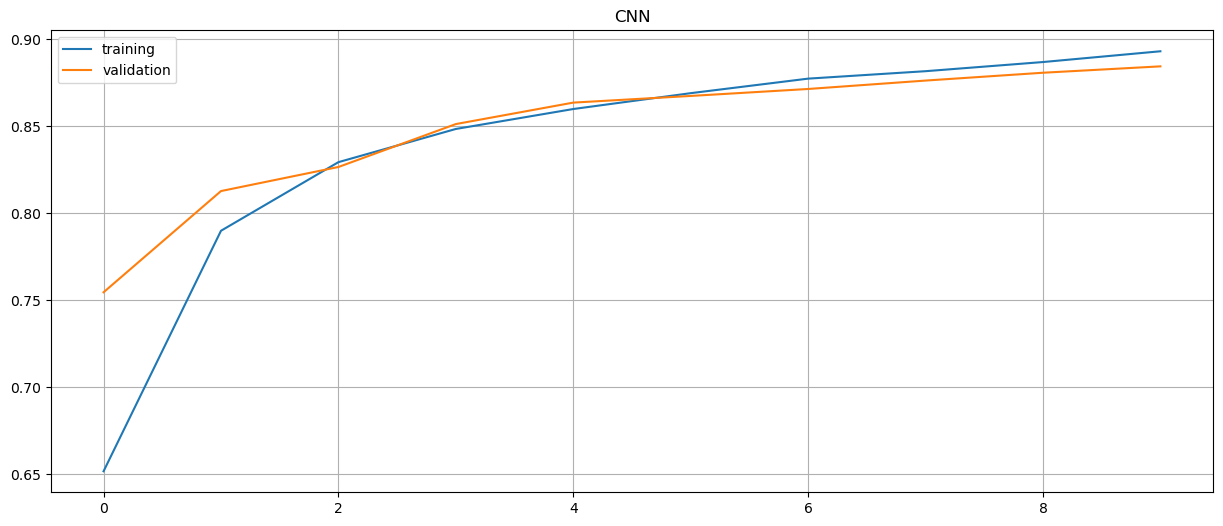

In [12]:
# Import matplotlib to plot the training history of the CNN model.
import matplotlib.pyplot as plt

# Create a figure with a specific size (15x6 inches) for the plot.
plt.figure(figsize=(15,6))

# Plot the training accuracy over the epochs from the history of the model.
# 'history_cnn.history['accuracy']' contains the training accuracy for each epoch.
# 'label='training'' is used to add a label to the plot for the training accuracy curve.
plt.plot(history_cnn.history['accuracy'], label='training')

# Plot the validation accuracy over the epochs from the history of the model.
# 'history_cnn.history['val_accuracy']' contains the validation accuracy for each epoch.
# 'label='validation'' is used to add a label to the plot for the validation accuracy curve.
plt.plot(history_cnn.history['val_accuracy'], label='validation')

# Set the title of the plot to 'CNN'.
plt.title('CNN')

# Add a legend to the plot to label the training and validation curves.
plt.legend()

# Display a grid on the plot for better readability of the values.
plt.grid()

# Show the plot.
plt.show()


In [13]:
print(logdir+'/tb_logs')

drive/MyDrive/02_Callbacks/tb_logs


In [14]:
# Launch from terminal:
%load_ext tensorboard
%tensorboard --logdir "drive/MyDrive/02_Callbacks/tb_logs"

Reusing TensorBoard on port 6006 (pid 3855), started 0:46:27 ago. (Use '!kill 3855' to kill it.)

In [15]:
# Get predictions from the model on the test data
# The model outputs probabilities for each class for each test sample
predictions = cnn_model.predict(x_test)

# Convert the probabilities into predicted class labels
# np.argmax returns the index of the maximum probability for each sample
# axis=1 indicates we are selecting the index along each row (per sample)
y_pred = np.argmax(predictions, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


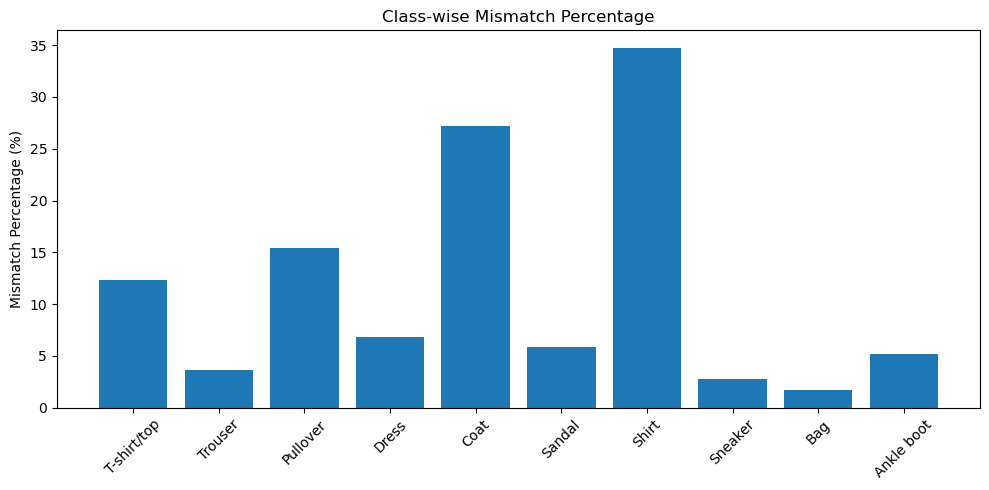

In [16]:
# Find mismatches
mismatch = np.where(y_pred != y_test)[0]
mismatch_class_counter = Counter(y_test[mismatch])
mismatch_percentage = {}

# Compute mismatch percentage per class
for digit in test_class_counter.keys():
    mismatch_percentage[digit] = mismatch_class_counter[digit] / test_class_counter[digit] * 100

# Create bar chart
plt.figure(figsize=(10, 5))
plt.bar(mismatch_percentage.keys(), mismatch_percentage.values())

# Set x-axis labels to class names
plt.xticks(ticks=list(mismatch_percentage.keys()), labels=[class_names[d] for d in mismatch_percentage.keys()], rotation=45)

plt.title('Class-wise Mismatch Percentage')
plt.ylabel('Mismatch Percentage (%)')
plt.tight_layout()
plt.show()


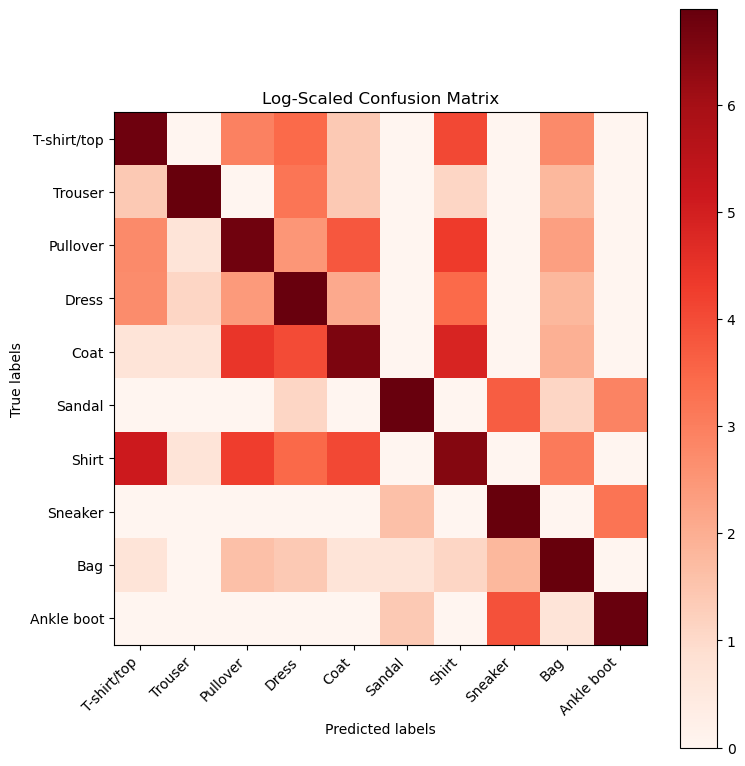

In [17]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix and take log for better visualization
cm = np.log(1 + confusion_matrix(y_test, y_pred))

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 8))

# Plot heatmap
im = ax.imshow(cm, interpolation='nearest', cmap='Reds')

# Add colorbar
fig.colorbar(im, ax=ax)

# Set axis labels
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')

# Set tick marks and labels to class names
ax.set_xticks(np.arange(len(class_names)))
ax.set_yticks(np.arange(len(class_names)))

ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.set_yticklabels(class_names)

# Optional: add gridlines for readability
ax.grid(False)

plt.title('Log-Scaled Confusion Matrix')
plt.tight_layout()
plt.show()

# Comparison with Feedforward Neural Network
Let's circle back to the Sequential model used in the last lab.

In [18]:
# --- KERAS ---
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input


def create_fnn_model(compile_model=False):
    model = Sequential([
        Input(shape=(28, 28)),              # input layer specifying the input shape           
        Flatten(),                          
        Dense(512, activation='relu'),      # dense layer with ReLU activation included 
        Dropout(0.2),                       
        Dense(10, activation='softmax')     # output layer with softmax activation   
    ])
    
    if compile_model:                       # we can add training parameters directly to the model
        model.compile(
            loss='sparse_categorical_crossentropy',  
            optimizer='adam',                        
            metrics=['accuracy']                     
        )
    
    return model  


In [19]:
# Create the FNN model
fnn_model = create_fnn_model(compile_model=True)

In [20]:
# Train the FNN model
history_fnn = fnn_model.fit(
    np.expand_dims(x_train, axis=3),  # Add the channel dimension (28, 28, 1)
    y_train,
    epochs=10,  # Train for 10 epochs
    validation_split=0.1,  # Use 10% of the training data for validation
    batch_size=1024  # Set the batch size
)

Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6283 - loss: 1.0782 - val_accuracy: 0.8303 - val_loss: 0.4994
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8260 - loss: 0.5093 - val_accuracy: 0.8478 - val_loss: 0.4355
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8508 - loss: 0.4395 - val_accuracy: 0.8612 - val_loss: 0.4005
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8585 - loss: 0.4028 - val_accuracy: 0.8632 - val_loss: 0.3820
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8670 - loss: 0.3756 - val_accuracy: 0.8708 - val_loss: 0.3697
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8762 - loss: 0.3590 - val_accuracy: 0.8742 - val_loss: 0.3548
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8774 - loss: 0.3430 - val_accuracy: 0.8760 - val_loss: 0.3392
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8852 - loss: 0.3212 - val_accuracy: 0.8775 - v

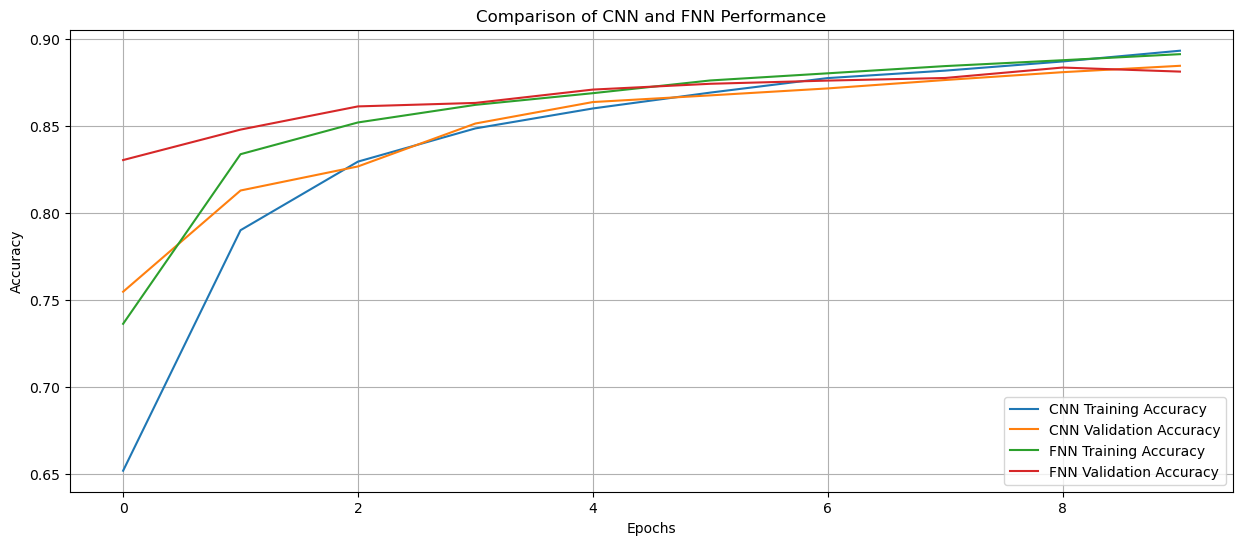

In [21]:
# Plot the training and validation accuracy for both the CNN and FNN

plt.figure(figsize=(15,6))

# Plot the CNN accuracy
plt.plot(history_cnn.history['accuracy'], label='CNN Training Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='CNN Validation Accuracy')

# Plot the FNN accuracy
plt.plot(history_fnn.history['accuracy'], label='FNN Training Accuracy')
plt.plot(history_fnn.history['val_accuracy'], label='FNN Validation Accuracy')

# Set the title and labels
plt.title('Comparison of CNN and FNN Performance')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Add grid for better readability
plt.grid()

# Show the plot
plt.show()

**NOTE**: When the images are in color, particularly with a higher number of training epochs, the performance improvement of the CNN over the FNN becomes more pronounced.

## Exercise 

In [22]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

Implement a CNN and test it on CIFAR10 dataset using Keras

Credits and solutions: [https://www.tensorflow.org/tutorials/images/cnn?hl=it](https://www.tensorflow.org/tutorials/images/cnn?hl=it)

**Download and prepare the CIFAR10 dataset**

The CIFAR10 dataset contains 60,000 color images in 10 classes, with 6,000 images in each class. The dataset is divided into 50,000 training images and 10,000 testing images. The classes are mutually exclusive and there is no overlap between them.

In [23]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = ..., ...

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 47s 0us/step


**Verify the data**

To verify that the dataset looks correct, let's plot the first 25 images from the training set and display the class name below each image:


TypeError: Image data of dtype object cannot be converted to float

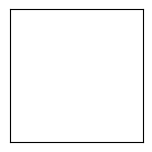

In [24]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(...)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

**Create the convolutional base and the dense layer on the top**

Create a model with: 
- Conv2D-MaxPooling2D-Conv2D-MaxPoolin2D-Conv2D
- Then,Properly add the dense layers on top, for classification. 

Compile the mode using usual arguments.

In [ ]:
#model = models....
#model.add(...)
...

#model....

Visualize the model structure

In [ ]:
...

Fit the model using 10 epochs

In [ ]:
...

Plot training curves on training and validation set

In [ ]:
# train accuracy
plt.plot(..., label='accuracy')
# validation accuracy
plt.plot(..., label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

Evaluate the model

In [ ]:
...

## Part 2: Keras vs PyTorch.

In [25]:
import tensorflow as tf
import torch
import numpy as np
from sklearn.model_selection import train_test_split

In [26]:
# --- Load MNIST dataset ---
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

print(type(x_train))

<class 'numpy.ndarray'>


In [27]:
# --- Load MNIST dataset ---
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

print(type(x_train))

<class 'numpy.ndarray'>


### Model definition: Sequential API (Keras vs Torhc)

In Lab 7, we saw how to define models using the `Sequential` API in Keras. PyTorch also has a similar concept with the `Sequential` container, but there are important differences between the two. Let’s explore both.


In [28]:
# --- MODEL DEFINITION WITH KERAS ---
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input


def create_model_keras(compile_model=False):
    model = Sequential([
        Input(shape=(28, 28)),              # input layer SPECYFING THE INPUT shape           
        Flatten(),                          
        Dense(512, activation='relu'),      # dense layer with ReLU activation included 
        Dropout(0.2),                       
        Dense(10, activation='softmax')     # output layer with softmax activation   
    ])
    
    if compile_model:                       # we can add training parameters directly to the model
        model.compile(
            loss='sparse_categorical_crossentropy',  
            optimizer='adam',                        
            metrics=['accuracy']                     
        )
    
    return model  

model_keras = create_model_keras(compile_model=True)

In [29]:
# --- MODEL DEFINITION WITH PYTORCH ---
from torch.nn import Sequential, Flatten, Linear, ReLU, Dropout
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

def create_model_pytorch(): 
    # Define a sequential model 
    model = Sequential( 
        # NO need of explicit input layer in PyTorch
        Flatten(),                                                                 
        Linear(in_features=784, out_features=512),        # Linear (Dense equivalent). Specify both input and output size
        ReLU(),                                           # Activation in a separate layer!
        Dropout(0.2),                                       
        Linear(in_features=512, out_features=10),         
                                                          # NO softmax here! The loss function CrossEntropyLoss() will apply softmax internally!! 
    )

    #NOTE: no compile method in PyTorch. We will use different objects for loss and optimizer.
    return model

model_torch = create_model_pytorch()
optimizer = Adam(model_torch.parameters())          # Careful: optimizer and loss are not part of the model in PyTorch
loss_fn = CrossEntropyLoss()                        # CrossEntropyLoss applies softmax internally, expects integers labels (not one-hot encoded)


### Training

In [31]:
# -- Keras --
model_keras.fit(x_train, y_train, epochs=5, batch_size=32, validation_split=0.1)        # very straightforward fit method. accept numpy arrays

Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.9885 - loss: 0.0349 - val_accuracy: 0.9830 - val_loss: 0.0645
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.9902 - loss: 0.0283 - val_accuracy: 0.9820 - val_loss: 0.0660
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.9917 - loss: 0.0247 - val_accuracy: 0.9855 - val_loss: 0.0655
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.9913 - loss: 0.0239 - val_accuracy: 0.9822 - val_loss: 0.0767
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.9928 - loss: 0.0209 - val_accuracy: 0.9820 - val_loss: 0.0816


In PyTorch we need to manually handle: 
- mini batch 
- train-validation split 
- evaluation (on both train set and val set)

Moreover, PyTorch requires torch.tensor and not numpy.array!

In [34]:
# -- PyTorch - Dà PIù CONTROLLO SU OGNI STEP DEL PROCESSO --
# --- 1: Without batching (i.e., full-batch gradient descent) ---

# Convert training data (NumPy arrays) to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)  # CrossEntropyLoss expects targets as Long tensors

# Split data into training and validation sets
val_split = 0.1
x_train_train, x_train_val, y_train_train, y_train_val = train_test_split(
    x_train_tensor, y_train_tensor, test_size=val_split
)

# Set number of training epochs
epochs = 5 

# Training loop
for epoch in range(epochs): 
    model_torch.train()                             # Set model to training mode (enables dropout, batch norm, etc.)
    optimizer.zero_grad()                           # Clear previous gradients (from last step)

    y_pred_logits = model_torch(x_train_train)      # FORWARD PASS: compute raw model outputs (logits)
    loss = loss_fn(y_pred_logits, y_train_train)    # Compute loss between predicted and true labels
    loss.backward()                                 # Backward pass: compute gradients w.r.t. model parameters
    optimizer.step()                                # Update model weights based on gradients

    # Calculate training accuracy (no gradient tracking needed here)
    with torch.no_grad(): 
        train_preds = torch.argmax(y_pred_logits, dim=1)             # Convert logits to predicted classes
        train_correct = (train_preds == y_train_train).sum().item()  # Count correct predictions
        train_acc = train_correct / y_train_train.size(0)            # Compute accuracy

    # Validation phase (disable dropout, batch norm)
    model_torch.eval()                         
    with torch.no_grad():                      # Don't compute gradients during evaluation
        y_pred_logits_val = model_torch(x_train_val)                    # Forward pass on validation data
        val_loss = loss_fn(y_pred_logits_val, y_train_val)             # Compute validation loss
        val_preds = torch.argmax(y_pred_logits_val, dim=1)             # Predicted class labels
        val_correct = (val_preds == y_train_val).sum().item()          # Count correct predictions
        val_acc = val_correct / y_train_val.size(0)                    # Compute validation accuracy

    # Print metrics for this epoch
    print(f"Epoch [{epoch+1}/{epochs}] | "
          f"Train Loss: {loss.item():.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss.item():.4f} | Val Acc: {val_acc:.4f}")


Epoch [1/5] | Train Loss: 0.0430 | Train Acc: 0.9862 | Val Loss: 0.0312 | Val Acc: 0.9910
Epoch [2/5] | Train Loss: 0.0430 | Train Acc: 0.9866 | Val Loss: 0.0313 | Val Acc: 0.9908
Epoch [3/5] | Train Loss: 0.0428 | Train Acc: 0.9865 | Val Loss: 0.0312 | Val Acc: 0.9908
Epoch [4/5] | Train Loss: 0.0436 | Train Acc: 0.9857 | Val Loss: 0.0312 | Val Acc: 0.9910
Epoch [5/5] | Train Loss: 0.0427 | Train Acc: 0.9858 | Val Loss: 0.0310 | Val Acc: 0.9910


In [33]:
# -- PyTorch --
# --- 2. With batching (mini-batch gradient descent) ---

from torch.utils.data import DataLoader, TensorDataset

# Create model, optimizer, and loss function
model_torch = create_model_pytorch()
optimizer = Adam(model_torch.parameters())  # In PyTorch, optimizer is defined separately
loss_fn = CrossEntropyLoss()                # CrossEntropyLoss includes softmax internally; expects integer (not one-hot) labels

# Convert data to tensors
x_data_tensor = torch.tensor(x_train, dtype=torch.float32)
y_data_tensor = torch.tensor(y_train, dtype=torch.long)

# Train-validation split
val_split = 0.1
x_train_tensor, x_val_tensor, y_train_tensor, y_val_tensor = train_test_split(
    x_data_tensor, y_data_tensor, test_size=val_split, random_state=42
)

# --- Create Datasets and DataLoaders ---
batch_size = 32  # Define mini-batch size (similar to Keras)

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  # No need to shuffle validation data

# Debug print to check number of batches per epoch
print(f"PyTorch training batches per epoch: {len(train_loader)}")
print(f"PyTorch validation batches per epoch: {len(val_loader)}")

# --- PyTorch Training Loop with Mini-Batches and Validation ---
print("\n--- PyTorch Training ---")
epochs = 5
for epoch in range(epochs):
    # --- Training Phase - iteriamo su più batch in ogni epoca ---
    model_torch.train()  # Set model to training mode (enables dropout, batch norm, etc.)
    running_train_loss = 0.0
    train_correct = 0
    train_total = 0

    # ! Iterate over training mini-batches (ovvero sul dataloader)
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        # Reset gradients from previous step
        optimizer.zero_grad()

        # Forward pass
        outputs = model_torch(inputs)
        loss = loss_fn(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate training loss and correct predictions
        running_train_loss += loss.item() * inputs.size(0)  # Sum loss weighted by batch size
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    # Compute average loss and accuracy for training epoch
    epoch_train_loss = running_train_loss / train_total
    epoch_train_acc = train_correct / train_total

    # --- Validation Phase ---
    model_torch.eval()  # Set model to evaluation mode (disables dropout, etc.)
    running_val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():  # Disable gradient tracking for evaluation
        for inputs, labels in val_loader:
            outputs = model_torch(inputs)
            loss = loss_fn(outputs, labels)

            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    # Compute average validation loss and accuracy
    epoch_val_loss = running_val_loss / val_total
    epoch_val_acc = val_correct / val_total

    # --- Epoch Summary ---
    print(f"Epoch [{epoch+1}/{epochs}] | "
          f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_acc:.4f}")
        

PyTorch training batches per epoch: 1688
PyTorch validation batches per epoch: 188

--- PyTorch Training ---
Epoch [1/5] | Train Loss: 0.2563 | Train Acc: 0.9259 | Val Loss: 0.1208 | Val Acc: 0.9655
Epoch [2/5] | Train Loss: 0.1084 | Train Acc: 0.9676 | Val Loss: 0.0824 | Val Acc: 0.9743
Epoch [3/5] | Train Loss: 0.0765 | Train Acc: 0.9760 | Val Loss: 0.0759 | Val Acc: 0.9768
Epoch [4/5] | Train Loss: 0.0594 | Train Acc: 0.9812 | Val Loss: 0.0635 | Val Acc: 0.9790
Epoch [5/5] | Train Loss: 0.0477 | Train Acc: 0.9841 | Val Loss: 0.0694 | Val Acc: 0.9803


As you can see, PyTorch requires significantly more code compared to Keras.
However, the training process is much clearer and more flexible for the user to adjust.

As we mentioned in the previous lecture, Keras has the advantage of simplicity,
while PyTorch excels in debugging and flexibility, making it more suitable for research purposes.

### Evaluation

In [35]:
# -- Keras --
# Evaluate the model on the test set (returns loss and accuracy)
test_loss, test_acc = model_keras.evaluate(x_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

# Make predictions on the test set
# The output is a probability distribution over classes for each sample
predictions = model_keras.predict(x_test)

# Convert predicted probabilities to class labels
y_pred = np.argmax(predictions, axis=1)

Test Loss: 0.0789 | Test Acc: 0.9795
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [36]:
# -- PyTorch --
model_torch.eval()  # Set the model to evaluation mode (disables dropout, batch norm, etc.)

# Convert test data to tensors
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Forward pass to get raw predictions (logits). 
#Con no_grad() calcolo le predizioni su cui calcolare l'attivazione per ottenere le labels
with torch.no_grad():  # Disable gradient tracking for evaluation
    y_pred_test_logits = model_torch(x_test_tensor)

# Convert logits to predicted class labels
y_pred_test = torch.argmax(y_pred_test_logits, dim=1)

# Compute test loss
test_loss = loss_fn(y_pred_test_logits, y_test_tensor).item()

# Compute test accuracy
test_correct = (y_pred_test == y_test_tensor).sum().item()
test_acc = test_correct / y_test_tensor.size(0)

print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")


Test Loss: 0.0717 | Test Acc: 0.9792


### Save and load models

In [37]:
destination_folder = "./drive/MyDrive/AA24-25ML/LAB8/"

# -- Keras --
model_keras.save(destination_folder + "model_keras.h5")
model_keras_loaded = tf.keras.models.load_model(destination_folder + "model_keras.h5") 

# -- PyTorch --
torch.save(model_torch, destination_folder + "model_torch.pth") 
model_torch_loaded = torch.load(destination_folder + "model_torch.pth", weights_only=False)

### Custom Model Definition in PyTorch

In the last lab, we saw how Keras allows for custom model creation by subclassing `tf.keras.Model` and implementing the `call()` method to define the forward pass.

PyTorch follows a similar approach!

To define a custom model in PyTorch, you subclass `torch.nn.Module` and implement two key methods:

- `__init__()` – defines the layers and architecture of the model.
- `forward()` – specifies the forward pass (equivalent to `call()` in Keras), i.e., how data flows through the model.

This structure gives you full flexibility to design complex models and control the computation process.


In [38]:
import torch.nn as nn
class MyModel(nn.Module): 
    def __init__(self): 
        super().__init__()
        self.flatten = Flatten()
        self.linear1 = Linear(784, 512)
        self.relu = ReLU()
        self.dropout = Dropout(0.2)
        self.linear2 = Linear(512, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x

model_torch = MyModel()